## The agent-environment interface

<img src="img/agent-environment.png" style="width: 500px;" align="left"/> 

<br><br><br>

The interaction of the agent with its environments starts at decision stage $t=0$ with the observation of the current state $s_0$. (Notice that there is no reward at this initial stage.) The agent then chooses an action to execute at decision stage $t=1$. The environment responds by changing its state to $s_1$ and returning the numerical reward signal $r_1$. 


## The environment: Navigation in a gridworld

<img src="img/gold.png" style="width: 250px;" align="left"/>

The agent has four possible actions in each state (grid square): west, north, south, and east. The actions are unreliable. They move the agent in the intended direction with probability 0.8, and with probability 0.2, they move the agent in a random other direction. If the direction of movement is blocked, the agent remains in the same grid square. The initial state of the agent is one of the five grid squares at the bottom, selected randomly. The grid squares with the gold and the bomb are **terminal states**. If the agent finds itself in one of these squares, the episode ends. Then a new episode begins with the agent at a randomly selected initial state.

You will use a reinforcement learning algorithm to compute the best policy for finding the gold with as few steps as possible while avoiding the bomb. For this, we will use the following reward function: $-1$ for each navigation action, an additional $+10$ for finding the gold, and an additional $-10$ for hitting the bomb. For example, the immediate reward for transitioning into the square with the gold is $-1 + 10 = +9$. Do not use discounting (that is, set $\gamma=1$).

## Q-Learning
For your reference, the pseudocode for the Q-Learning algorithm is reproduced below (Reinforcement Learning, Sutton & Barto, 2018, Section 6.5 p.131).
<img src="img/q.png" style="width: 720px;"/>


## Example of a learning curve

<img src="img/lc_example.png" style="width: 550px;" align="left"/>

<br><br><br><br>

This is a sample learning curve and shows the reward obtained by a Q-learning agent across 500 episodes. Do not try to replicate this exact curve! It was computed using a different environment than the one described here.

In [1]:
# YOUR CODE HERE!

import numpy as np
import operator
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Gridworld():
    
    def __init__(self):
        # Inititalize all the data
        self.rows = 5
        self.columns = 5
        self.reward = np.zeros((self.rows, self.columns)) - 1

        # Location of bomb 
        self.bomb_location = (1, 3)
        self.gold_location = (0, 3)

        # Terminal state
        self.terminal_state = [self.bomb_location, self.gold_location]

        # Start location of agent
        self.current_location = (4, np.random.randint(0,5))

        # Set special grid rewards
        self.reward[1, 3] = -10
        self.reward[0, 3] = 10

        # Set available actions

        self.actions = ['UP','DOWN','LEFT','RIGHT']
    
    def get_available_actions(self):
        # Returns the list of actions available
        return self.actions
    
    def get_current_location(self):
        # Return a matrix of current location of agent with a 1
        grid = np.zeros((self.rows, self.columns))
        grid[self.current_location[0]. self.current_location[1]] = 1
        return grid
    
    def get_reward(self, new_location):
        # Return the reward of current position
        return self.reward[new_location[0], new_location[1]]
    
    def make_a_move(self, action):
        # Moves the agent in the specified action direction and if its on the border, dont make a move and return -1
        # Function returns the reward
        previous_location = self.current_location

        if action == 'UP':
            if previous_location[0] == 0:
                reward = self.get_reward(self.current_location)
            else:
                self.current_location = (self.current_location[0] - 1, self.current_location[1])
                reward = self.get_reward(self.current_location)
                
        elif action == 'DOWN':
            if previous_location[0] == 4:
                reward = self.get_reward(self.current_location)
            else:
                self.current_location = (self.current_location[0] + 1, self.current_location[1])
                reward = self.get_reward(self.current_location)
                
        elif action == 'LEFT':
            if previous_location[1] == 0:
                reward = self.get_reward(self.current_location)
            else:
                self.current_location = (self.current_location[0], self.current_location[1] - 1)
                reward = self.get_reward(self.current_location)
            
        elif action == 'RIGHT':
            if previous_location[1] == 4:
                reward = self.get_reward(self.current_location)
            else:
                self.current_location = (self.current_location[0], self.current_location[1] + 1)
                reward = self.get_reward(self.current_location)
        
        return reward
    
    
    def check_terminal_state(self):
        # Return end of episode when agent reaches bomb or gold
        if self.current_location in self.terminal_state:
            return 'EndOfEpisode'
    
# Class for the agent. Agent should not be able to access the position of bomb and gold. hence a different class
class RandomAgent():
    # Choose a random action
    def choose_random_action(available_actions):
        return np.random.choice(available_actions)
           

In [3]:
# Class for QAgent - Determines the Q-Table by the Greedy algorithm as mentioned, 
# Chooses the optimum action, does some intialization too.

class QAgent():
    def __init__(self, environment, epsilon = 0.05, gamma = 1, alpha = 0.1):
        self.environment = environment           # intiliaze env
        self.q_table = dict()                   # create qtable dict
        for i in range(environment.rows):
            for j in range(environment.columns):
                self.q_table[(i,j)] = {'UP':0, 'DOWN':0, 'LEFT':0, 'RIGHT':0}         # Nested dictionary # Fill the qtable with empty values for moves
            
        self.epsilon = epsilon
        self.gamma = gamma
        self.alpha = alpha
        
    def choose_optimum_action(self, available_actions):
        # Return optimal action from qvalue table. If multiple optimal action, then choose randomly 
        if np.random.uniform(0,1) < self.epsilon:
            action = available_actions[np.random.randint(0, len(available_actions))]
        else:
            qvalues_of_state = self.q_table[self.environment.current_location]
            max_value = max(qvalues_of_state.values())
            action = np.random.choice([k for k,v in qvalues_of_state.items() if v == max_value])
        return action
    
    def update_QValue(self, old_state, new_state, reward, action):
        # Update Qvalue according to algorithm 
        qvalues = self.q_table[new_state]
        max_qvalue_new_state = max(qvalues.values())
        current_q_value = self.q_table[old_state][action]
        
        self.q_table[old_state][action] = (1 - self.alpha) * current_q_value + self.alpha * (reward + self.gamma * max_qvalue_new_state)
    

In [4]:
def play(environment, agent, trials = 500, max_step_per_episode = 1000, learn = False):
    # Runs iteration and updates q values
    reward_for_episode = []
    
    for trial in range(trials):
        cumulative_reward = 0
        step = 0
        game_over = False
        while step < max_step_per_episode and game_over == False:
            old_state = environment.current_location
            action = agent.choose_optimum_action(environment.actions)
            reward = environment.make_a_move(action)
            new_state = environment.current_location
            
            if learn == True:
                agent.update_QValue(old_state, new_state, reward, action)
                
            cumulative_reward += reward
            step += 1
            
            print("Cumulative reward", cumulative_reward)
            if environment.check_terminal_state() == 'EndOfEpisode':
                environment.__init__()
                game_over = True
                
        reward_for_episode.append(cumulative_reward)   #Append reward for current trial to peformance
        
    return reward_for_episode
        

In [5]:
# env = Gridworld()
# agent = RandomAgent()

# print("Current position of the agent =", env.current_location)
# print(env.get_current_location())
# available_actions = env.get_available_actions()
# print("Available_actions =", available_actions)
# chosen_action = agent.choose_action(available_actions)
# print("Randomly chosen action =", chosen_action)
# reward = env.make_step(chosen_action)
# print("Reward obtained =", reward)
# print("Current position of the agent =", env.current_location)
# print(env.get_current_location())



Old State (4, 4)
Choosing optimal action.....
{(0, 0): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}, (0, 1): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}, (0, 2): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}, (0, 3): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}, (0, 4): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}, (1, 0): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}, (1, 1): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}, (1, 2): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}, (1, 3): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}, (1, 4): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}, (2, 0): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}, (2, 1): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}, (2, 2): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}, (2, 3): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}, (2, 4): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}, (3, 0): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}, (3, 1): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}, (3, 2): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0},

New state (4, 1)
Cumulative reward -79.0
Old State (4, 1)
Choosing optimal action.....
Action LEFT
Reward -1.0
New state (4, 0)
Cumulative reward -80.0
Old State (4, 0)
Choosing optimal action.....
{(0, 0): {'UP': -0.1, 'DOWN': -0.1, 'LEFT': -0.1, 'RIGHT': -0.1}, (0, 1): {'UP': 0, 'DOWN': -0.1, 'LEFT': -0.1, 'RIGHT': 0}, (0, 2): {'UP': 0, 'DOWN': -0.1, 'LEFT': 0, 'RIGHT': 0}, (0, 3): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}, (0, 4): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}, (1, 0): {'UP': -0.1, 'DOWN': -0.2, 'LEFT': -0.1, 'RIGHT': -0.1}, (1, 1): {'UP': -0.1, 'DOWN': -0.11000000000000001, 'LEFT': -0.1, 'RIGHT': -0.1}, (1, 2): {'UP': -0.1, 'DOWN': -0.1, 'LEFT': 0, 'RIGHT': -1.0}, (1, 3): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}, (1, 4): {'UP': 0, 'DOWN': -0.1, 'LEFT': 0, 'RIGHT': 0}, (2, 0): {'UP': -0.19, 'DOWN': -0.20900000000000002, 'LEFT': -0.2, 'RIGHT': -0.2}, (2, 1): {'UP': -0.19, 'DOWN': -0.2, 'LEFT': -0.2, 'RIGHT': -0.1}, (2, 2): {'UP': -0.1, 'DOWN': -0.11000000000000001,

Reward -1.0
New state (3, 1)
Cumulative reward -2.0
Old State (3, 1)
Choosing optimal action.....
{(0, 0): {'UP': -0.2, 'DOWN': -0.2, 'LEFT': -0.2, 'RIGHT': -0.2}, (0, 1): {'UP': -0.2, 'DOWN': -0.201, 'LEFT': -0.1, 'RIGHT': -0.09000000000000001}, (0, 2): {'UP': 0, 'DOWN': -0.1, 'LEFT': -0.1, 'RIGHT': 2.71}, (0, 3): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}, (0, 4): {'UP': 0, 'DOWN': 0, 'LEFT': 1.0, 'RIGHT': 0}, (1, 0): {'UP': -0.29000000000000004, 'DOWN': -0.30000000000000004, 'LEFT': -0.30000000000000004, 'RIGHT': -0.29000000000000004}, (1, 1): {'UP': -0.19, 'DOWN': -0.21900000000000003, 'LEFT': -0.30900000000000005, 'RIGHT': -0.29000000000000004}, (1, 2): {'UP': -0.08100000000000002, 'DOWN': -0.21000000000000002, 'LEFT': -0.21800000000000003, 'RIGHT': -1.0}, (1, 3): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}, (1, 4): {'UP': -0.1, 'DOWN': -0.2192, 'LEFT': -1.0, 'RIGHT': -0.1}, (2, 0): {'UP': -0.3729, 'DOWN': -0.30810000000000004, 'LEFT': -0.30000000000000004, 'RIGHT': -0.2900000000

Old State (4, 1)
Choosing optimal action.....
{(0, 0): {'UP': -0.2, 'DOWN': -0.2, 'LEFT': -0.2, 'RIGHT': -0.2}, (0, 1): {'UP': -0.2, 'DOWN': -0.201, 'LEFT': -0.1, 'RIGHT': 0.3905100000000001}, (0, 2): {'UP': 0, 'DOWN': -0.1, 'LEFT': -0.1, 'RIGHT': 4.68559}, (0, 3): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}, (0, 4): {'UP': 0, 'DOWN': 0, 'LEFT': 1.0, 'RIGHT': 0}, (1, 0): {'UP': -0.29000000000000004, 'DOWN': -0.30000000000000004, 'LEFT': -0.30000000000000004, 'RIGHT': -0.3829000000000001}, (1, 1): {'UP': -0.3430000000000001, 'DOWN': -0.32810000000000006, 'LEFT': -0.30900000000000005, 'RIGHT': -0.29000000000000004}, (1, 2): {'UP': 0.17099999999999999, 'DOWN': -0.21000000000000002, 'LEFT': -0.21800000000000003, 'RIGHT': -1.0}, (1, 3): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}, (1, 4): {'UP': -0.1, 'DOWN': -0.33656, 'LEFT': -1.0, 'RIGHT': -0.1}, (2, 0): {'UP': -0.46461, 'DOWN': -0.41729000000000005, 'LEFT': -0.4000000000000001, 'RIGHT': -0.49207100000000004}, (2, 1): {'UP': -0.4635200000

{(0, 0): {'UP': -0.30000000000000004, 'DOWN': -0.2, 'LEFT': -0.30000000000000004, 'RIGHT': -0.24094900000000002}, (0, 1): {'UP': -0.2, 'DOWN': -0.201, 'LEFT': -0.1, 'RIGHT': 0.8209917900000001}, (0, 2): {'UP': 0, 'DOWN': -0.1, 'LEFT': -0.1, 'RIGHT': 6.5132155990000005}, (0, 3): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}, (0, 4): {'UP': 0, 'DOWN': 0, 'LEFT': 2.71, 'RIGHT': 0}, (1, 0): {'UP': -0.38100000000000006, 'DOWN': -0.30000000000000004, 'LEFT': -0.30000000000000004, 'RIGHT': -0.3829000000000001}, (1, 1): {'UP': -0.3430000000000001, 'DOWN': -0.32810000000000006, 'LEFT': -0.30900000000000005, 'RIGHT': -0.3087541000000001}, (1, 2): {'UP': 1.3153040910000002, 'DOWN': -0.21000000000000002, 'LEFT': -0.21800000000000003, 'RIGHT': -1.0}, (1, 3): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}, (1, 4): {'UP': 0.00899999999999998, 'DOWN': -0.33656, 'LEFT': -1.0, 'RIGHT': -0.1}, (2, 0): {'UP': -0.5471490000000001, 'DOWN': -0.53549458, 'LEFT': -0.5000000000000001, 'RIGHT': -0.49207100000000004},

New state (4, 0)
Cumulative reward -15.0
Old State (4, 0)
Choosing optimal action.....
{(0, 0): {'UP': -0.30000000000000004, 'DOWN': -0.2, 'LEFT': -0.30000000000000004, 'RIGHT': -0.24094900000000002}, (0, 1): {'UP': -0.2, 'DOWN': -0.201, 'LEFT': -0.1, 'RIGHT': 0.8209917900000001}, (0, 2): {'UP': 0, 'DOWN': -0.1, 'LEFT': -0.1, 'RIGHT': 7.94108867905351}, (0, 3): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}, (0, 4): {'UP': 0, 'DOWN': 0, 'LEFT': 3.439, 'RIGHT': 0}, (1, 0): {'UP': -0.38100000000000006, 'DOWN': -0.42930359000000007, 'LEFT': -0.4000000000000001, 'RIGHT': -0.3829000000000001}, (1, 1): {'UP': -0.3430000000000001, 'DOWN': -0.32810000000000006, 'LEFT': -0.30900000000000005, 'RIGHT': -0.16310117784700004}, (1, 2): {'UP': 3.318424289946541, 'DOWN': -0.21000000000000002, 'LEFT': -0.21800000000000003, 'RIGHT': -1.9}, (1, 3): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}, (1, 4): {'UP': 0.17909999999999998, 'DOWN': -0.33656, 'LEFT': -1.0, 'RIGHT': -0.1}, (2, 0): {'UP': -0.62243410000000

Action LEFT
Reward 10.0
New state (0, 3)
Cumulative reward 4.0
Old State (4, 2)
Choosing optimal action.....
{(0, 0): {'UP': -0.30000000000000004, 'DOWN': -0.31829, 'LEFT': -0.30000000000000004, 'RIGHT': -0.24094900000000002}, (0, 1): {'UP': -0.2, 'DOWN': -0.201, 'LEFT': -0.1, 'RIGHT': 0.8209917900000001}, (0, 2): {'UP': 0.7649148282327008, 'DOWN': 0.27719396354459297, 'LEFT': -0.1, 'RIGHT': 9.113706188034751}, (0, 3): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}, (0, 4): {'UP': 0, 'DOWN': 0, 'LEFT': 5.6953279000000006, 'RIGHT': 0}, (1, 0): {'UP': -0.46290000000000003, 'DOWN': -0.5563732310000001, 'LEFT': -0.5000000000000001, 'RIGHT': -0.4735953242385079}, (1, 1): {'UP': -0.3430000000000001, 'DOWN': -0.32810000000000006, 'LEFT': -0.30900000000000005, 'RIGHT': 0.7665601395699335}, (1, 2): {'UP': 5.951938184242663, 'DOWN': -0.21000000000000002, 'LEFT': -0.21800000000000003, 'RIGHT': -1.9}, (1, 3): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}, (1, 4): {'UP': 1.2994199100000001, 'DOWN': -0.3

Cumulative reward -2.0
Old State (3, 4)
Choosing optimal action.....
{(0, 0): {'UP': -0.30000000000000004, 'DOWN': -0.31829, 'LEFT': -0.30000000000000004, 'RIGHT': -0.24094900000000002}, (0, 1): {'UP': -0.2, 'DOWN': -0.201, 'LEFT': -0.1, 'RIGHT': 0.8209917900000001}, (0, 2): {'UP': 0.7649148282327008, 'DOWN': 0.27719396354459297, 'LEFT': -0.1, 'RIGHT': 9.797244404095549}, (0, 3): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}, (0, 4): {'UP': 0, 'DOWN': 0, 'LEFT': 5.6953279000000006, 'RIGHT': 0}, (1, 0): {'UP': -0.46290000000000003, 'DOWN': -0.5563732310000001, 'LEFT': -0.5000000000000001, 'RIGHT': -0.4735953242385079}, (1, 1): {'UP': -0.3430000000000001, 'DOWN': -0.32810000000000006, 'LEFT': -0.30900000000000005, 'RIGHT': 1.8182071407795546}, (1, 2): {'UP': 7.987303630881135, 'DOWN': -0.21000000000000002, 'LEFT': -0.21800000000000003, 'RIGHT': -1.9}, (1, 3): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}, (1, 4): {'UP': 1.2994199100000001, 'DOWN': -0.33656, 'LEFT': -1.0, 'RIGHT': -0.1}, (2, 

Action UP
Reward -1.0
New state (1, 2)
Cumulative reward -3.0
Old State (1, 2)
Choosing optimal action.....
{(0, 0): {'UP': -0.30000000000000004, 'DOWN': -0.31829, 'LEFT': -0.30000000000000004, 'RIGHT': -0.234754921}, (0, 1): {'UP': -0.2, 'DOWN': -0.041577927953760946, 'LEFT': -0.1, 'RIGHT': 0.8209917900000001}, (0, 2): {'UP': 0.7649148282327008, 'DOWN': 0.27719396354459297, 'LEFT': -0.1, 'RIGHT': 9.966186080864777}, (0, 3): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}, (0, 4): {'UP': 0, 'DOWN': 0, 'LEFT': 6.12579511, 'RIGHT': 0}, (1, 0): {'UP': -0.5407049, 'DOWN': -0.5563732310000001, 'LEFT': -0.5000000000000001, 'RIGHT': -0.4735953242385079}, (1, 1): {'UP': -0.3430000000000001, 'DOWN': -0.32810000000000006, 'LEFT': -0.30900000000000005, 'RIGHT': 2.9143425477518488}, (1, 2): {'UP': 8.767240050311807, 'DOWN': -0.21000000000000002, 'LEFT': -0.11437928592204458, 'RIGHT': -1.9}, (1, 3): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}, (1, 4): {'UP': 1.6390107090000003, 'DOWN': -0.33656, 'LEFT'

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Action UP
Reward -1.0
New state (3, 3)
Cumulative reward -2.0
Old State (3, 3)
Choosing optimal action.....
{(0, 0): {'UP': -0.30000000000000004, 'DOWN': -0.31829, 'LEFT': -0.30000000000000004, 'RIGHT': -0.234754921}, (0, 1): {'UP': -0.2, 'DOWN': -0.041577927953760946, 'LEFT': -0.1, 'RIGHT': 2.3749887388277724}, (0, 2): {'UP': 1.5883387039116021, 'DOWN': 1.7443554593464308, 'LEFT': -0.03322288938163856, 'RIGHT': 9.999999996250644}, (0, 3): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}, (0, 4): {'UP': 0, 'DOWN': 0, 'LEFT': 7.175704635190001, 'RIGHT': 0}, (1, 0): {'UP': -0.5407049, 'DOWN': -0.5563732310000001, 'LEFT': -0.5000000000000001, 'RIGHT': -0.4735953242385079}, (1, 1): {'UP': -0.3430000000000001, 'DOWN': -0.32810000000000006, 'LEFT': -0.30900000000000005, 'RIGHT': 4.283391214246002}, (1, 2): {'UP': 8.99999992026319, 'DOWN': 1.157625680380104, 'LEFT': 0.5757662643405393, 'RIGHT': -2.71}, (1, 3): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}, (1, 4): {'UP': 2.692407018591001, 'DOWN': 

Action UP
Reward -1.0
New state (1, 2)
Cumulative reward -3.0
Old State (1, 2)
Choosing optimal action.....
{(0, 0): {'UP': -0.30000000000000004, 'DOWN': -0.31829, 'LEFT': -0.30000000000000004, 'RIGHT': -0.234754921}, (0, 1): {'UP': -0.2, 'DOWN': -0.041577927953760946, 'LEFT': -0.1, 'RIGHT': 2.3749887388277724}, (0, 2): {'UP': 1.5883387039116021, 'DOWN': 2.3699199110185947, 'LEFT': -0.03322288938163856, 'RIGHT': 9.999999998941073}, (0, 3): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}, (0, 4): {'UP': 0, 'DOWN': 0, 'LEFT': 7.175704635190001, 'RIGHT': 0}, (1, 0): {'UP': -0.5407049, 'DOWN': -0.5563732310000001, 'LEFT': -0.5000000000000001, 'RIGHT': -0.4735953242385079}, (1, 1): {'UP': -0.3430000000000001, 'DOWN': -0.32810000000000006, 'LEFT': -0.30900000000000005, 'RIGHT': 4.283391214246002}, (1, 2): {'UP': 8.999999978343602, 'DOWN': 1.157625680380104, 'LEFT': 0.5757662643405393, 'RIGHT': -2.71}, (1, 3): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}, (1, 4): {'UP': 2.692407018591001, 'DOWN': 

Cumulative reward -2.0
Old State (3, 2)
Choosing optimal action.....
{(0, 0): {'UP': -0.30000000000000004, 'DOWN': -0.31829, 'LEFT': -0.30000000000000004, 'RIGHT': -0.234754921}, (0, 1): {'UP': -0.2, 'DOWN': -0.041577927953760946, 'LEFT': -0.1, 'RIGHT': 3.03748986490397}, (0, 2): {'UP': 2.329504833450966, 'DOWN': 2.9329279186032085, 'LEFT': 0.10759827343930253, 'RIGHT': 9.999999999841062}, (0, 3): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}, (0, 4): {'UP': 0, 'DOWN': 0, 'LEFT': 7.458134171671, 'RIGHT': 0}, (1, 0): {'UP': -0.5407049, 'DOWN': -0.5563732310000001, 'LEFT': -0.5000000000000001, 'RIGHT': -0.4735953242385079}, (1, 1): {'UP': -0.3430000000000001, 'DOWN': -0.32810000000000006, 'LEFT': -0.30900000000000005, 'RIGHT': 4.283391214246002}, (1, 2): {'UP': 8.999999996747837, 'DOWN': 1.157625680380104, 'LEFT': 0.5757662643405393, 'RIGHT': -2.71}, (1, 3): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}, (1, 4): {'UP': 3.040736780250901, 'DOWN': -0.33656, 'LEFT': -1.0, 'RIGHT': -0.1}, (2, 0)

Reward 10.0
New state (0, 3)
Cumulative reward 5.0
Old State (4, 0)
Choosing optimal action.....
{(0, 0): {'UP': -0.30000000000000004, 'DOWN': -0.31829, 'LEFT': -0.30000000000000004, 'RIGHT': -0.234754921}, (0, 1): {'UP': -0.2, 'DOWN': -0.041577927953760946, 'LEFT': -0.1, 'RIGHT': 3.03748986490397}, (0, 2): {'UP': 2.329504833450966, 'DOWN': 2.9329279186032085, 'LEFT': 0.10759827343930253, 'RIGHT': 9.999999999980679}, (0, 3): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}, (0, 4): {'UP': 0, 'DOWN': 0, 'LEFT': 7.458134171671, 'RIGHT': 0}, (1, 0): {'UP': -0.5407049, 'DOWN': -0.5563732310000001, 'LEFT': -0.5000000000000001, 'RIGHT': -0.4735953242385079}, (1, 1): {'UP': -0.3430000000000001, 'DOWN': -0.32810000000000006, 'LEFT': -0.30900000000000005, 'RIGHT': 4.283391214246002}, (1, 2): {'UP': 8.999999999561677, 'DOWN': 1.7418631115150993, 'LEFT': 0.5757662643405393, 'RIGHT': -2.71}, (1, 3): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}, (1, 4): {'UP': 3.040736780250901, 'DOWN': -0.33656, 'LEFT':

Cumulative reward -2.0
Old State (2, 2)
Choosing optimal action.....
{(0, 0): {'UP': -0.30000000000000004, 'DOWN': -0.31829, 'LEFT': -0.30000000000000004, 'RIGHT': -0.234754921}, (0, 1): {'UP': -0.2, 'DOWN': -0.041577927953760946, 'LEFT': -0.1, 'RIGHT': 3.6337408784121648}, (0, 2): {'UP': 2.329504833450966, 'DOWN': 2.9329279186032085, 'LEFT': 0.3005874325857693, 'RIGHT': 9.999999999994543}, (0, 3): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}, (0, 4): {'UP': 0, 'DOWN': 0, 'LEFT': 7.458134171671, 'RIGHT': 0}, (1, 0): {'UP': -0.5407049, 'DOWN': -0.5563732310000001, 'LEFT': -0.5000000000000001, 'RIGHT': -0.4735953242385079}, (1, 1): {'UP': -0.3430000000000001, 'DOWN': -0.32810000000000006, 'LEFT': -0.30900000000000005, 'RIGHT': 4.283391214246002}, (1, 2): {'UP': 8.999999999868933, 'DOWN': 1.7418631115150993, 'LEFT': 0.5757662643405393, 'RIGHT': -2.71}, (1, 3): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}, (1, 4): {'UP': 3.040736780250901, 'DOWN': -0.33656, 'LEFT': -1.0, 'RIGHT': -0.1}, (2, 

Choosing optimal action.....
{(0, 0): {'UP': -0.30000000000000004, 'DOWN': -0.31829, 'LEFT': -0.30000000000000004, 'RIGHT': -0.234754921}, (0, 1): {'UP': -0.2, 'DOWN': -0.041577927953760946, 'LEFT': -0.1, 'RIGHT': 4.170366790570794}, (0, 2): {'UP': 2.329504833450966, 'DOWN': 2.9329279186032085, 'LEFT': 0.5339027771684088, 'RIGHT': 9.999999999999263}, (0, 3): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}, (0, 4): {'UP': 0, 'DOWN': 0, 'LEFT': 7.458134171671, 'RIGHT': 0}, (1, 0): {'UP': -0.5407049, 'DOWN': -0.5563732310000001, 'LEFT': -0.5000000000000001, 'RIGHT': -0.4735953242385079}, (1, 1): {'UP': -0.3430000000000001, 'DOWN': -0.32810000000000006, 'LEFT': -0.30900000000000005, 'RIGHT': 4.283391214246002}, (1, 2): {'UP': 8.999999999982595, 'DOWN': 1.7418631115150993, 'LEFT': 0.5757662643405393, 'RIGHT': -2.71}, (1, 3): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}, (1, 4): {'UP': 3.040736780250901, 'DOWN': -0.33656, 'LEFT': -1.0, 'RIGHT': -0.1}, (2, 0): {'UP': -0.9002267236106232, 'DOWN': -

Cumulative reward -3.0
Old State (1, 2)
Choosing optimal action.....
{(0, 0): {'UP': -0.30000000000000004, 'DOWN': -0.31829, 'LEFT': -0.30000000000000004, 'RIGHT': -0.234754921}, (0, 1): {'UP': -0.2, 'DOWN': -0.041577927953760946, 'LEFT': -0.1, 'RIGHT': 4.170366790570794}, (0, 2): {'UP': 2.996554350105816, 'DOWN': 2.9329279186032085, 'LEFT': 0.5339027771684088, 'RIGHT': 9.999999999999904}, (0, 3): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}, (0, 4): {'UP': 0, 'DOWN': 0, 'LEFT': 7.458134171671, 'RIGHT': 0}, (1, 0): {'UP': -0.5407049, 'DOWN': -0.5563732310000001, 'LEFT': -0.5000000000000001, 'RIGHT': -0.4735953242385079}, (1, 1): {'UP': -0.3430000000000001, 'DOWN': -0.32810000000000006, 'LEFT': -0.30900000000000005, 'RIGHT': 4.283391214246002}, (1, 2): {'UP': 8.99999999999719, 'DOWN': 2.2676768003414427, 'LEFT': 0.5757662643405393, 'RIGHT': -2.71}, (1, 3): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}, (1, 4): {'UP': 3.040736780250901, 'DOWN': -0.33656, 'LEFT': -1.0, 'RIGHT': -0.1}, (2, 0)

New state (2, 2)
Cumulative reward -4.0
Old State (2, 2)
Choosing optimal action.....
{(0, 0): {'UP': -0.30000000000000004, 'DOWN': -0.31829, 'LEFT': -0.30000000000000004, 'RIGHT': -0.234754921}, (0, 1): {'UP': -0.2, 'DOWN': -0.041577927953760946, 'LEFT': -0.1, 'RIGHT': 4.170366790570794}, (0, 2): {'UP': 2.996554350105816, 'DOWN': 2.9329279186032085, 'LEFT': 0.5339027771684088, 'RIGHT': 9.99999999999998}, (0, 3): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}, (0, 4): {'UP': 0, 'DOWN': 0, 'LEFT': 7.458134171671, 'RIGHT': 0}, (1, 0): {'UP': -0.5407049, 'DOWN': -0.5563732310000001, 'LEFT': -0.5000000000000001, 'RIGHT': -0.4735953242385079}, (1, 1): {'UP': -0.3430000000000001, 'DOWN': -0.32810000000000006, 'LEFT': -0.30900000000000005, 'RIGHT': 4.283391214246002}, (1, 2): {'UP': 8.999999999999325, 'DOWN': 2.7409091203055587, 'LEFT': 0.5757662643405393, 'RIGHT': -2.71}, (1, 3): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}, (1, 4): {'UP': 3.040736780250901, 'DOWN': -0.33656, 'LEFT': -1.0, 'RIGH

Reward -1.0
New state (3, 3)
Cumulative reward -2.0
Old State (3, 3)
Choosing optimal action.....
{(0, 0): {'UP': -0.30000000000000004, 'DOWN': -0.31829, 'LEFT': -0.30000000000000004, 'RIGHT': -0.234754921}, (0, 1): {'UP': -0.2, 'DOWN': -0.041577927953760946, 'LEFT': -0.1, 'RIGHT': 4.653330111513714}, (0, 2): {'UP': 2.996554350105816, 'DOWN': 2.9329279186032085, 'LEFT': 0.7975491785086475, 'RIGHT': 9.999999999999995}, (0, 3): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}, (0, 4): {'UP': 0, 'DOWN': 0, 'LEFT': 7.458134171671, 'RIGHT': 0}, (1, 0): {'UP': -0.5407049, 'DOWN': -0.5563732310000001, 'LEFT': -0.5000000000000001, 'RIGHT': -0.4735953242385079}, (1, 1): {'UP': -0.3430000000000001, 'DOWN': -0.32810000000000006, 'LEFT': -0.30900000000000005, 'RIGHT': 4.283391214246002}, (1, 2): {'UP': 8.999999999999883, 'DOWN': 2.7409091203055587, 'LEFT': 0.5757662643405393, 'RIGHT': -2.71}, (1, 3): {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}, (1, 4): {'UP': 3.040736780250901, 'DOWN': -0.33656, 'LEFT'

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



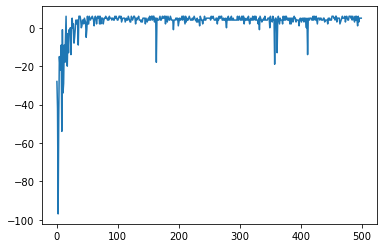

In [6]:
environment = Gridworld()
agentQ = QAgent(environment)

# Note the learn=True argument!
reward_per_episode = play(environment, agentQ, trials=500, learn=True)

# Simple learning curve
plt.plot(reward_per_episode)